<a href="https://colab.research.google.com/github/davario/sector_classifier/blob/main/sector_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python

import tensorflow as tf

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import sklearn.model_selection as sk

import plotly.express as px

import re

In [5]:
# Input data files are available in the "../input/" directory.
import os
print("Input files:")
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Input files:


In [6]:
# Any results you write to the current directory are saved as output.

# For neural nets with my GPU, RNN doesn't work without this in TF 2.0
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

print()
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")


TF Version:  2.4.1
Eager mode:  True
GPU is available
GPU found


In [20]:
from google.colab import files
uploaded = files.upload()

Saving training_data.xlsx to training_data (1).xlsx


In [21]:
import io
dfdata = pd.read_excel(io.BytesIO(uploaded["training_data.xlsx"]))
# Dataset is now stored in a Pandas Dataframe
dfdata.info()
print()
print(dfdata.shape)
print(dfdata.columns)
dfdata.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2278 entries, 0 to 2277
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   NACE2              2278 non-null   object
 1   Trade_description  2278 non-null   object
dtypes: object(2)
memory usage: 35.7+ KB

(2278, 2)
Index(['NACE2', 'Trade_description'], dtype='object')


,NACE2,Trade_description
0,"D - Electricity, gas, steam and air conditioni...","La produzione, il trasporto e il commercio di ..."
1,C - Manufacturing,Das Unternehmen wurde in 1959 gegruendet. Es i...
2,G - Wholesale and retail trade; repair of moto...,Mettere a disposizione dei propri soci e della...
3,H - Transportation and storage,L'esercizio della ferrovia a scartamento ridot...
4,"R - Arts, entertainment and recreation",Promuovere e diffondere i sentimenti patriotti...


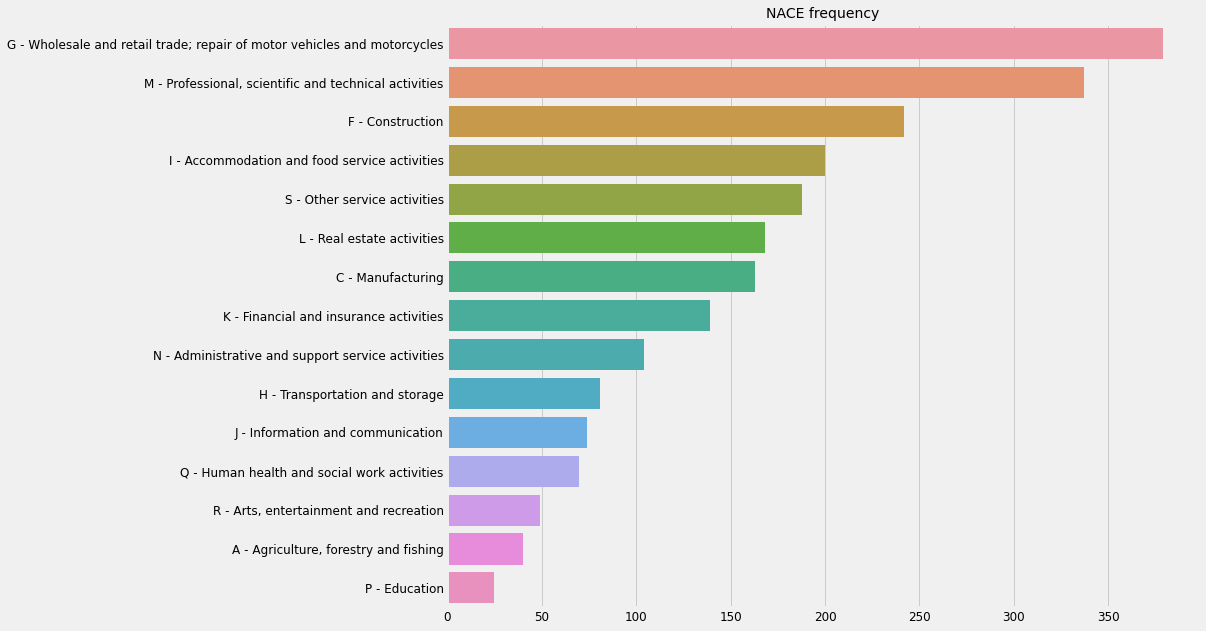

In [22]:
# Get label frequencies in descending order
label_freq = dfdata['NACE2'].apply(lambda s: str(s)).explode().value_counts().sort_values(ascending=False)

# Bar plot
style.use("fivethirtyeight")
plt.figure(figsize=(12,10))
sns.barplot(y=label_freq.index.values, x=label_freq, order=label_freq.iloc[:15].index)
plt.title("NACE frequency", fontsize=14)
plt.xlabel("")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [23]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [24]:
import nltk
from nltk.corpus import stopwords
stop = stopwords.words('italian')
stop

['ad',
 'al',
 'allo',
 'ai',
 'agli',
 'all',
 'agl',
 'alla',
 'alle',
 'con',
 'col',
 'coi',
 'da',
 'dal',
 'dallo',
 'dai',
 'dagli',
 'dall',
 'dagl',
 'dalla',
 'dalle',
 'di',
 'del',
 'dello',
 'dei',
 'degli',
 'dell',
 'degl',
 'della',
 'delle',
 'in',
 'nel',
 'nello',
 'nei',
 'negli',
 'nell',
 'negl',
 'nella',
 'nelle',
 'su',
 'sul',
 'sullo',
 'sui',
 'sugli',
 'sull',
 'sugl',
 'sulla',
 'sulle',
 'per',
 'tra',
 'contro',
 'io',
 'tu',
 'lui',
 'lei',
 'noi',
 'voi',
 'loro',
 'mio',
 'mia',
 'miei',
 'mie',
 'tuo',
 'tua',
 'tuoi',
 'tue',
 'suo',
 'sua',
 'suoi',
 'sue',
 'nostro',
 'nostra',
 'nostri',
 'nostre',
 'vostro',
 'vostra',
 'vostri',
 'vostre',
 'mi',
 'ti',
 'ci',
 'vi',
 'lo',
 'la',
 'li',
 'le',
 'gli',
 'ne',
 'il',
 'un',
 'uno',
 'una',
 'ma',
 'ed',
 'se',
 'perché',
 'anche',
 'come',
 'dov',
 'dove',
 'che',
 'chi',
 'cui',
 'non',
 'più',
 'quale',
 'quanto',
 'quanti',
 'quanta',
 'quante',
 'quello',
 'quelli',
 'quella',
 'quelle',
 'q

Remove italian stopwords

In [33]:
import nltk
from nltk.corpus import stopwords
stop = stopwords.words('italian')


def StopWordCleanser(word):
    if word in stop:
        return ""
    else:
        return word

dfdata['Trade_description'] = dfdata['Trade_description'].map(lambda Trade_description: Trade_description.lower())
dfdata['Trade_description'] = dfdata['Trade_description'].map(lambda Trade_description: Trade_description.replace("'", " "))
dfdata['Trade_description'] = dfdata['Trade_description'].map(lambda Trade_description: Trade_description.replace(",", " "))
dfdata['Trade_description'] = dfdata['Trade_description'].apply(lambda x: " ".join([StopWordCleanser(i) for i in str(x).split()]))


In [34]:
dfdata['Trade_description'] 

0       produzione trasporto commercio energia elettri...
1       das unternehmen wurde 1959 gegruendet. es ist ...
2       mettere disposizione propri soci popolazione g...
3       esercizio ferrovia scartamento ridotto locarno...
4       promuovere diffondere sentimenti patriottici i...
                              ...                        
2273    esercizio impresa generale (general contractor...
2274    acquisto vendita consulenza riparazione import...
2275    gestione spazio creativo ambito artistico tutt...
2276    consulenza realizzazione lavori costruzione ma...
2277                  commercio oggetti servono scrivere.
Name: Trade_description, Length: 2278, dtype: object

# New Section

In [39]:
# length of dictionary
NUM_WORDS = 5000

# Length of each description
SEQ_LEN = 250

#create tokenizer for our data
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=NUM_WORDS, oov_token='<UNK>', filters='!"#$%&()*+,./:;<=>?@[\\]^`{|}~\t\n')
tokenizer.fit_on_texts(dfdata['Trade_description'])

#convert text data to numerical indexes
sect_seqs=tokenizer.texts_to_sequences(dfdata['Trade_description'])

#pad data up to SEQ_LEN (note that we truncate if there are more than SEQ_LEN tokens)
sect_seqs=tf.keras.preprocessing.sequence.pad_sequences(sect_seqs, maxlen=SEQ_LEN, padding="post")

print(sect_seqs)

[[  46  155   22 ...    0    0    0]
 [1530  648 4225 ...    0    0    0]
 [ 575  258  192 ...    0    0    0]
 ...
 [   8 1891 3675 ...    0    0    0]
 [  17   90   41 ...    0    0    0]
 [  22  218 1644 ...    0    0    0]]


In [40]:

nace_labels=pd.DataFrame({'NACE2': dfdata['NACE2']})
# wine_labels=wine_labels.replace({'variety' : char2idx})
nace_labels=nace_labels.replace(' ', '_', regex=True)

nace_labels_list = []
for item in nace_labels['NACE2']:
    nace_labels_list.append(str(item))

label_tokenizer = tf.keras.preprocessing.text.Tokenizer(split=' ', filters='!"#$%&()*+,./:;<=>?@[\\]^`{|}~\t\n')
label_tokenizer.fit_on_texts(nace_labels_list)

label_nace = list(label_freq[label_freq>=0].index)
print(label_nace)

num_labels = len(label_nace)


print(len(label_nace))
print(label_tokenizer.word_index)

nace_label_seq = np.array(label_tokenizer.texts_to_sequences(nace_labels_list))

#wine_label_seq.reshape(129864, 1)
nace_label_seq.shape
#print(wine_label_seq)

['G - Wholesale and retail trade; repair of motor vehicles and motorcycles', 'M - Professional, scientific and technical activities', 'F - Construction', 'I - Accommodation and food service activities', 'S - Other service activities', 'L - Real estate activities', 'C - Manufacturing', 'K - Financial and insurance activities', 'N - Administrative and support service activities', 'H - Transportation and storage', 'J - Information and communication', 'Q - Human health and social work activities', 'R - Arts, entertainment and recreation', 'A - Agriculture, forestry and fishing', 'P - Education', 'D - Electricity, gas, steam and air conditioning supply', 'E - Water supply; sewerage, waste management and remediation activities']
17
{'g_-_wholesale_and_retail_trade': 1, '_repair_of_motor_vehicles_and_motorcycles': 2, 'm_-_professional': 3, '_scientific_and_technical_activities': 4, 'f_-_construction': 5, 'i_-_accommodation_and_food_service_activities': 6, 's_-_other_service_activities': 7, 'l

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



(2278,)

In [41]:
reverse_word_index = dict([(value, key) for (key, value) in tokenizer.word_index.items()])

def decode_article(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])


reverse_label_index = dict([(value, key) for (key, value) in label_tokenizer.word_index.items()])

def decode_label(text):
    return ' '.join([reverse_label_index.get(i, '?') for i in text])

In [42]:
# Demonstrate what the input looks like, how it gets encoded.

test_entry=3

print(decode_article(sect_seqs[test_entry]))
print('---')
print(sect_seqs[test_entry])

print(decode_label(nace_label_seq[test_entry]))
print('---')
print(nace_label_seq[test_entry])

esercizio ferrovia scartamento ridotto locarno camedo confine italo-svizzero centovalli giusta concessione federale 23 06 1905 linea locarno-camedo ulteriori modificazioni esercizio autolinee urbane extra-urbane secondo concessioni ottenute dipartimento federale trasporti comunicazioni energie attuali future costruzione esercizio altre ferrovie filovie linee navigazione auto filobus quali società divenire concessionaria pure esercizio linee ferroviarie conto altre società proprietarie ogni altra impresa accessoria dipendente esercizio trasporti costruzione affitto acquisto terreni gestione immobili autorimesse hangar immobili deposito merci nonché costruzione esercizio impianti energetici compera energia altre imprese elettriche vendita locazione energia altre imprese ferroviarie enti pubblici persone private organizzazione promozione trasporti turistici purché tale attività svolta esclusivamente limiti scopo principale società assunzione genere qualsiasi impresa trasporto tanto canton

In [43]:
label_words=dfdata['NACE2'].unique()
number_class=len(dfdata['NACE2'].unique())
dict_nace= {i: label_words[i] for i in range(0, len(label_words))}
inv_dict_nace= {v: k for k, v in dict_nace.items()}
nace_label_seq2=dfdata['NACE2'].map(inv_dict_nace)
nace_label_seq2=pd.Series(nace_label_seq2)
nace_label_seq2=nace_label_seq2.to_frame()
nace_label_seq2=nace_label_seq2.values

nace_label_seq2.shape
nace_label_seq2=nace_label_seq2+1
print(nace_label_seq2)
len(nace_label_seq2)
print(number_class)

[[ 1]
 [ 2]
 [ 3]
 ...
 [10]
 [14]
 [ 7]]
17


In [44]:
# Divide into two
X_train, X_test, y_train, y_test = sk.train_test_split(sect_seqs,
                                                    nace_label_seq2,
                                                    test_size=0.15,
                                                    random_state=42)

print('Test: ' + str(len(X_test)) + ' Train: ' + str(len(X_train)))

X_train = X_train.astype("float32")
X_test = X_test.astype("float32")


y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

print(type(X_train), X_train.shape)

# X_train = X_train / 1024.0
# X_test = X_test / 1024.0
# y_train = y_train / 1024.0
# y_test = y_test / 1024.0

print(X_train.shape)
print(y_train.shape)

Test: 342 Train: 1936
<class 'numpy.ndarray'> (1936, 250)
(1936, 250)
(1936, 1)


In [45]:
print(label_nace)




['G - Wholesale and retail trade; repair of motor vehicles and motorcycles', 'M - Professional, scientific and technical activities', 'F - Construction', 'I - Accommodation and food service activities', 'S - Other service activities', 'L - Real estate activities', 'C - Manufacturing', 'K - Financial and insurance activities', 'N - Administrative and support service activities', 'H - Transportation and storage', 'J - Information and communication', 'Q - Human health and social work activities', 'R - Arts, entertainment and recreation', 'A - Agriculture, forestry and fishing', 'P - Education', 'D - Electricity, gas, steam and air conditioning supply', 'E - Water supply; sewerage, waste management and remediation activities']


In [46]:
print(X_train.shape)

print(y_train.shape)
len(label_words)
print(X_test.shape)

(1936, 250)
(1936, 1)
(342, 250)


In [69]:

t= (tf.keras.layers.Embedding(NUM_WORDS, EMBEDDING_SIZE))
tf.shape(t)

ValueError: ignored

In [95]:
EMBEDDING_SIZE = 300
EMBEDDING_SIZE_2 = 300
EMBEDDING_SIZE_3 = (num_labels+1)
BATCH_SIZE = 171  # This can really speed things up
EPOCHS = 10
LR = 1e-5  # Keep it small when transfer learning

# model = tf.keras.Sequential([
#     tf.keras.layers.Embedding(NUM_WORDS, EMBEDDING_SIZE),
#     tf.keras.layers.GlobalAveragePooling1D(),
#     tf.keras.layers.Dense(1, activation='relu', name='output')])
# #    tf.keras.layers.Dense(1, activation='sigmoid')])
# #    tf.keras.layers.Dense(len(idx2char), activation='relu', name='hidden_layer')])

# https://towardsdatascience.com/multi-class-text-classification-with-lstm-using-tensorflow-2-0-d88627c10a35
model = tf.keras.Sequential([
    
    # Add an Embedding layer expecting input vocab of a given size, and output embedding dimension of fized size we set at the top
    tf.keras.layers.Embedding(NUM_WORDS, EMBEDDING_SIZE),
#     tf.keras.layers.Embedding(input_dim=NUM_WORDS, 
#                            output_dim=EMBEDDING_SIZE, 
#                            input_length=SEQ_LEN), 
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(EMBEDDING_SIZE)),
    tf.keras.layers.Conv1D(300, 5, activation='relu'), 
    tf.keras.layers.Dropout(.0, input_shape=(300,)),
    tf.keras.layers.GlobalMaxPooling1D(), 
    
    # use ReLU in place of tanh function since they are very good alternatives of each other.
    tf.keras.layers.Dense(EMBEDDING_SIZE_2, activation='relu'),
      tf.keras.layers.Dropout(.0, input_shape=(EMBEDDING_SIZE_2,)),
    # Add a Dense layer with additional units and softmax activation.
    # When we have multiple outputs, softmax convert outputs layers into a probability distribution.
    tf.keras.layers.Dense(EMBEDDING_SIZE_3, activation='softmax')
])

model.summary()

model.compile(optimizer='adam',
#                optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
#               loss='binary_crossentropy',
              loss='sparse_categorical_crossentropy',
#               loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, None, 300)         1500000   
_________________________________________________________________
conv1d_16 (Conv1D)           (None, None, 300)         450300    
_________________________________________________________________
dropout_16 (Dropout)         (None, None, 300)         0         
_________________________________________________________________
global_max_pooling1d_15 (Glo (None, 300)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 300)               90300     
_________________________________________________________________
dropout_17 (Dropout)         (None, 300)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 18)              

In [89]:
steps_per_epoch = len(X_train)//BATCH_SIZE
validation_steps_num = len(X_test)//BATCH_SIZE # if you have test data
validation_steps_num


2

In [97]:
# Directory where the checkpoints will be saved
checkpoint_dir = './checkpoints/classifer_training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    monitor='accuracy',
    save_best_only=True,
    mode='auto',
    save_weights_only=True)

history = model.fit(X_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_test, y_test),
                    validation_steps=validation_steps_num,
                   callbacks=[checkpoint_callback]
                    )

# es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max')
# callbacks=[es]
# history = model.fit(X_train, y_train,
#                     batch_size=BATCH_SIZE,
#                     epochs=EPOCHS,
#                     validation_data=(X_test, y_test),
#                     callbacks=callbacks)

loss, accuracy = model.evaluate(X_test, y_test)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

Epoch 1/10
12/12 [==============================] - 1s 81ms/step - loss: 0.0910 - accuracy: 0.9933 - val_loss: 1.4427 - val_accuracy: 0.6316
Epoch 2/10
12/12 [==============================] - 1s 70ms/step - loss: 0.0577 - accuracy: 0.9954 - val_loss: 1.4771 - val_accuracy: 0.6140
Epoch 3/10
12/12 [==============================] - 1s 72ms/step - loss: 0.0411 - accuracy: 0.9969 - val_loss: 1.4800 - val_accuracy: 0.6345
Epoch 4/10
12/12 [==============================] - 1s 71ms/step - loss: 0.0309 - accuracy: 0.9964 - val_loss: 1.5172 - val_accuracy: 0.6199
Epoch 5/10
12/12 [==============================] - 1s 71ms/step - loss: 0.0300 - accuracy: 0.9969 - val_loss: 1.5238 - val_accuracy: 0.6404
Epoch 6/10
12/12 [==============================] - 1s 71ms/step - loss: 0.0244 - accuracy: 0.9974 - val_loss: 1.5633 - val_accuracy: 0.6345
Epoch 7/10
12/12 [==============================] - 1s 71ms/step - loss: 0.0172 - accuracy: 0.9979 - val_loss: 1.5313 - val_accuracy: 0.6491
Epoch 8/10
12

In [ ]:
tf.train.latest_checkpoint(checkpoint_dir)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([1, None]))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 600)         3000000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 300)         900300    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 600)               180600    
_________________________________________________________________
dense_3 (Dense)              (None, 18)                10818     
Total params: 4,091,718
Trainable params: 4,091,718
Non-trainable params: 0
_________________________________________________________________


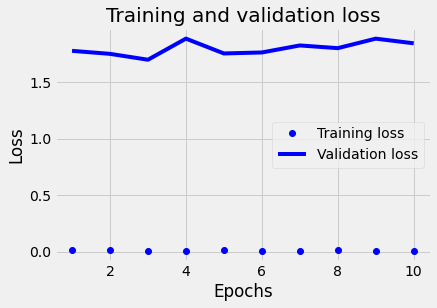

In [ ]:
history_dict = history.history
history_dict.keys()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

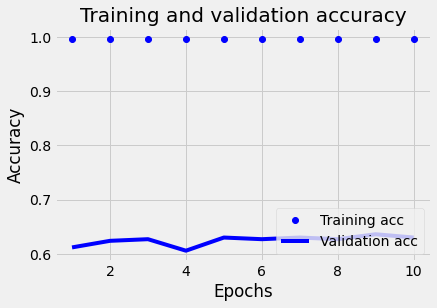

In [ ]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [ ]:
def sample_predict(sample_pred_text, pad):
  encoded_sample_pred_text = tokenizer.texts_to_sequences(sample_pred_text)
  print(encoded_sample_pred_text)
  print(type(encoded_sample_pred_text))

  if pad:
    encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, SEQ_LEN)
    
  encoded_sample_pred_text = np.array(encoded_sample_pred_text)
  encoded_sample_pred_text = encoded_sample_pred_text.astype("float32")
  predictions = model.predict(encoded_sample_pred_text)

In [ ]:
new_review = ['La gestione di bar, ristoranti, discoteche e esercizi pubblici in genere, inclusa l attività di catering e la preparazione e la vendita di pasti da asporto, l organizzazione di eventi di ogni genere in conto proprio o per conto di terzi. La società può comprare, vendere, importare, esportare, confezionare alimenti e bevande e prodotti gastronomici. La società può svolgere ogni attività finanziaria o immobiliare o di altro genere in relazione diretta o indiretta con lo scopo sociale. La società può aprire succursali in Svizzera e all estero e partecipare a società aventi scopo analogo']
encoded_sample_pred_text = tokenizer.texts_to_sequences(new_review)
# Some models need padding, some don't - depends on the embedding layer.
encoded_sample_pred_text = tf.keras.preprocessing.sequence.pad_sequences(encoded_sample_pred_text, maxlen=SEQ_LEN, padding="post")
predictions = model.predict(encoded_sample_pred_text)

for n in reversed((np.argsort(predictions))[0]):
    predicted_id = [n]
    #print("Guess: %s \n Probability: %f" %(decode_label(predicted_id).replace('_', ' '), 100*predictions[0][predicted_id][0]) + '%')
    print("Guess: %s \n Probability: %f" %(dict_nace[n-1], 100*predictions[0][predicted_id][0]) + '%')

NameError: ignored